In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from clusters_2dplot import plot2dclust
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
import statsmodels.api as sm
from scipy.stats import combine_pvalues
import seaborn as sns
sns.set_theme()


seed = 222
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['figure.dpi'] = 80

In [2]:
d = pd.read_csv('data_1389741.txt', sep=' ')

In [3]:
d.head()

,CRP,TBC1D29,TAS2R30,LOC284751,GRIP2,CENPI,C9orf24,ZNF33B,ALG11,TDRD10,...,FOXRED2,SLC22A4,AQP1.1,SPAG7,ZDHHC1,QPRT,POLR3D,FZD2,SH2D3C,GATA4
0,0.198831,4.014521,4.085804,4.730332,4.292702,4.461839,3.724150,7.794586,7.008939,3.571351,...,3.611962,8.355842,3.991811,7.533213,4.028854,5.087264,5.323413,3.707459,7.756686,3.605002
1,0.228771,3.546167,3.311993,4.435809,4.300570,3.747224,4.684504,7.893544,7.427287,3.416544,...,3.178713,7.752335,3.789425,8.429006,3.711739,4.579850,5.386979,3.874820,7.188841,3.511260
2,-0.023988,3.621861,4.460689,5.262007,3.876074,3.722994,3.511537,7.831839,7.180306,4.576185,...,3.835756,7.925043,3.876156,7.337425,3.658373,4.625407,5.243675,3.641726,7.786836,3.924219
3,-0.784348,3.902407,3.272875,4.776516,4.219379,3.329654,4.107894,7.863497,7.272451,3.147170,...,3.857577,8.404783,4.038103,7.465370,3.775955,5.186791,5.246684,3.797120,7.825768,3.636972
4,0.064758,3.943810,3.371475,4.820366,4.163395,3.871468,4.453357,7.521866,7.031714,4.038536,...,3.837243,9.019095,4.293670,7.565465,4.391240,5.242332,5.581444,4.229338,8.204718,3.410152


In [4]:
X = d.drop(['CRP'], axis=1)
X = X.T
sc = StandardScaler()
X = sc.fit_transform(X)

### Clustering of features

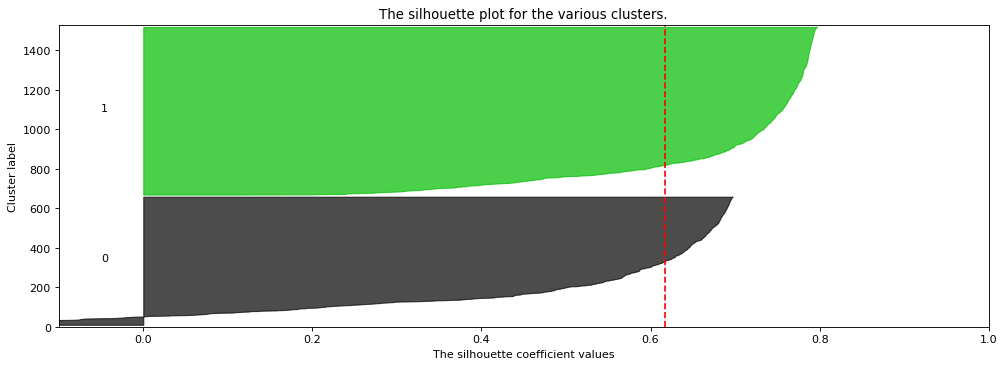

In [5]:
all_cls = range(2,30,1)
plt2d = plot2dclust(X, tp = 'km')
all_siluets = plt2d.clustering(aggclust=True, range_n_clusters=all_cls)

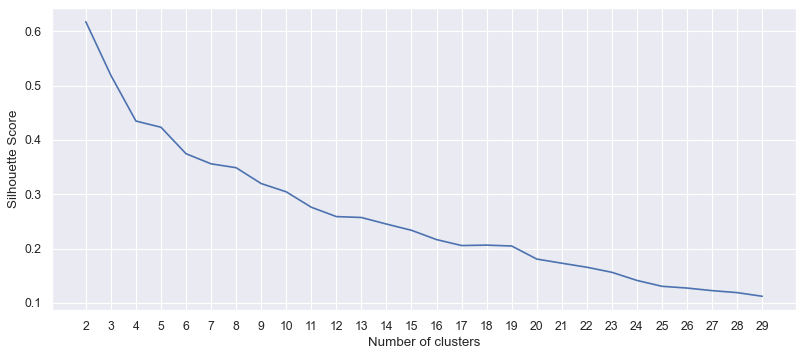

In [40]:
plt.plot(all_cls, all_siluets)
plt.xticks(all_cls)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.savefig('plots/sil_clus.pdf')
plt.show()

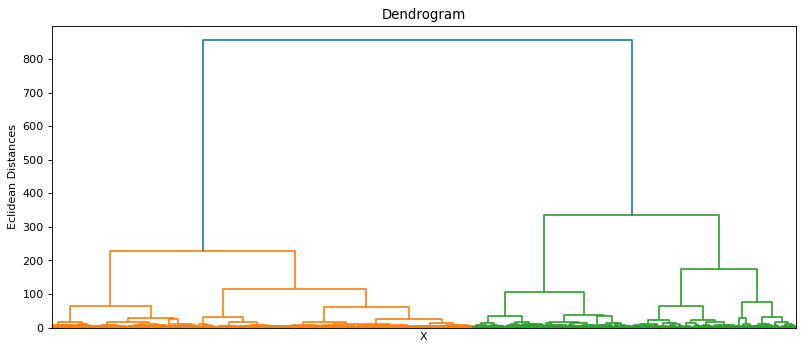

[18.60772441 14.90757066 12.81282383 ... 22.58104236 23.0607291
 13.66485488]


In [7]:
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid

import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'), 
    show_leaf_counts=False, no_labels=False)
plt.title("Dendrogram")
plt.xlabel("X")
plt.ylabel("Eclidean Distances")
plt.savefig('plots/dendogram.pdf')
plt.xticks([])
plt.show()

clusterer = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
y_predict = clusterer.fit_predict(X)
cluster_labels = clusterer.labels_

clf = NearestCentroid(metric='euclidean')
clf.fit(X, y_predict)

y = pdist(d)
print(y)

In [8]:
X_new = d.drop(['CRP'], axis=1).T
sc = StandardScaler()
X_new = pd.DataFrame(sc.fit_transform(X_new), columns=X_new.columns)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_new)
clusters_linear = kmeans.predict(X_new)


nameofcol = 'cluster_'
X_new[nameofcol] = clusters_linear
#Try PCA for visulization
plotX = X_new
plotX.columns = X_new.columns

#PCA with two principal components
pca_2d = PCA(n_components=2)

#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop([nameofcol], axis=1)))

PCs_2d.columns = ["PC1_2d", "PC2_2d"]

plotX = pd.concat([plotX,PCs_2d],axis=1, join='inner')
cluster0 = plotX[plotX[nameofcol] == 0]
cluster1 = plotX[plotX[nameofcol] == 1]
#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

data = [trace1, trace2]

title = ""

layout = dict(title = title,
            xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
            yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
            )

fig = dict(data = data, layout = layout)

iplot(fig)

In [9]:
print('Number of genes in Cluster 1: {} \nNumber of genes in Cluster 2: {}'.format(
    clusters_linear.sum(), len(clusters_linear) - clusters_linear.sum()))

Number of genes in Cluster 1: 584 
Number of genes in Cluster 2: 916


## Part 2

In [10]:
def model_fit(m, X, y, plot = False):

    y_hat = m.predict(X)
    rmse = mean_squared_error(y, y_hat, squared=False)
    res = pd.DataFrame(
            data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    if plot:
            plt.figure(figsize=(12, 6))
            plt.subplot(121)
            sns.lineplot(x='y', y='y_hat', color="grey", 
            data = pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
            sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
            plt.subplot(122)
            sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
            plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
            plt.savefig('plots/lasso.pdf')
            plt.show()
    return(rmse)

In [65]:
d = pd.read_csv('data_1389741.txt', sep=' ')
y = np.squeeze(d[['CRP']].values)
X = d.drop(['CRP'], axis=1).values
print(y.shape)
print(X.shape)

X1 = np.squeeze(np.take(X, np.where(clusters_linear == 0), axis=1), axis=1)
X2 = np.squeeze(np.take(X, np.where(clusters_linear == 1), axis=1), axis=1)
print(X1.shape)
print(X2.shape)

(335,)
(335, 1500)
(335, 916)
(335, 584)


In [66]:
def do_pca(X_mat, y, show_plot=False):
    pca = PCA()
    X_reduced = pca.fit_transform(scale(X_mat))
    print(X_reduced.shape)
    var_expl = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    if show_plot:
        plt.plot(var_expl)
        plt.ylabel('% Explained Variance')
        plt.xlabel('Number of PC Components')
        plt.xticks(np.arange(0, 350, 20, dtype=int))
        plt.savefig('variance_explained_1.pdf')
        plt.show()
    #split the dataset into training (70%) and testing (30%) sets
    n_components = np.where(var_expl >=85)[0][0]
    print('first point that 85% of the variance is explained: {} PCs'.format(n_components))

    new_X = X_reduced[:,:n_components + 1]
    est = sm.OLS(y, new_X).fit()


    return est
    

(335, 335)


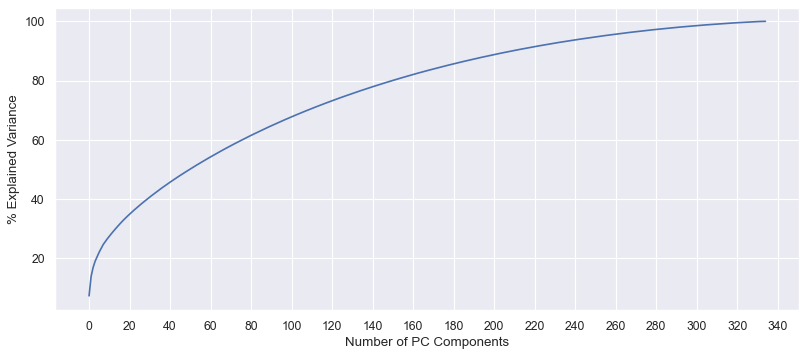

first point that 85% of the variance is explained: 177 PCs


Dep. Variable:,y,R-squared (uncentered):,0.804
Model:,OLS,Adj. R-squared (uncentered):,0.583
Method:,Least Squares,F-statistic:,3.627
Date:,"Wed, 20 Apr 2022",Prob (F-statistic):,9.65e-16
Time:,23:06:20,Log-Likelihood:,-201.54
No. Observations:,335,AIC:,759.1
Df Residuals:,157,BIC:,1438.
Df Model:,178,,
Covariance Type:,nonrobust,,


In [67]:
est = do_pca(X1, y, show_plot=True)
est.summary().tables[0]

(335, 335)


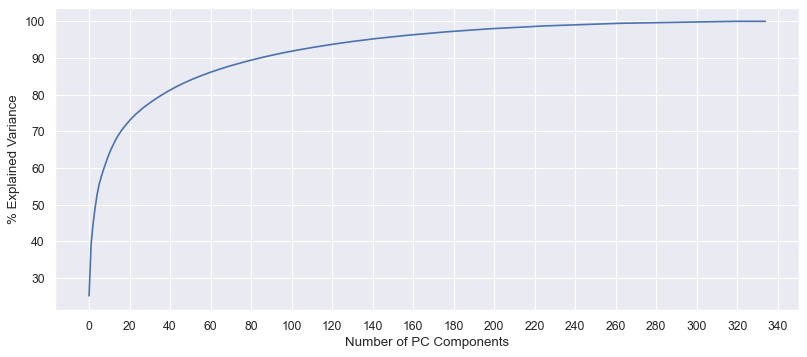

first point that 85% of the variance is explained: 55 PCs


Dep. Variable:,y,R-squared (uncentered):,0.341
Model:,OLS,Adj. R-squared (uncentered):,0.209
Method:,Least Squares,F-statistic:,2.577
Date:,"Wed, 20 Apr 2022",Prob (F-statistic):,1.96e-07
Time:,23:06:58,Log-Likelihood:,-405.01
No. Observations:,335,AIC:,922.0
Df Residuals:,279,BIC:,1136.
Df Model:,56,,
Covariance Type:,nonrobust,,


In [68]:
est2 = do_pca(X2, y, show_plot=True)
est2.summary().tables[0]

### Self-Contained Method

In [28]:
d = pd.read_csv('data_1389741.txt', sep=' ')
y = np.squeeze(d[['CRP']].values)
X = d.drop(['CRP'], axis=1).values
X1 = np.squeeze(np.take(X, np.where(clusters_linear == 0), axis=1), axis=1)
X2 = np.squeeze(np.take(X, np.where(clusters_linear == 1), axis=1), axis=1)
print(X1.shape)
print(X2.shape)

(335, 916)
(335, 584)


In [29]:
def LR(X,y, i):
    est = sm.OLS(y, X[:,i]).fit()
    p_val = est.pvalues[0]
    return p_val

In [30]:
def Bootstrap_Fisher(B, X_matrix, y_arr): 
    all_fish_statistics = []
    np.random.seed(42)
    for b in range(B):
        if b != 0:
            np.random.shuffle(y_arr)

        all_p_values = []
        for i in range(X_matrix.shape[1]):
            pval = LR(X_matrix, y_arr, i)
            all_p_values.append(pval)

        fisher_statistic, _ = combine_pvalues(all_p_values, method = 'fisher')
        all_fish_statistics.append(fisher_statistic)

    TS_observed = all_fish_statistics[0]
    TS_permuted = all_fish_statistics[1:]
    actual_pval = (np.count_nonzero(TS_permuted >= TS_observed) + 1 ) / (B + 1)
    return(TS_observed, TS_permuted, actual_pval)

In [33]:
tso_1, tsp_1 , actual_pval1 = Bootstrap_Fisher(B=1000, X_matrix=X1, y_arr=y)
actual_pval1

0.000999000999000999

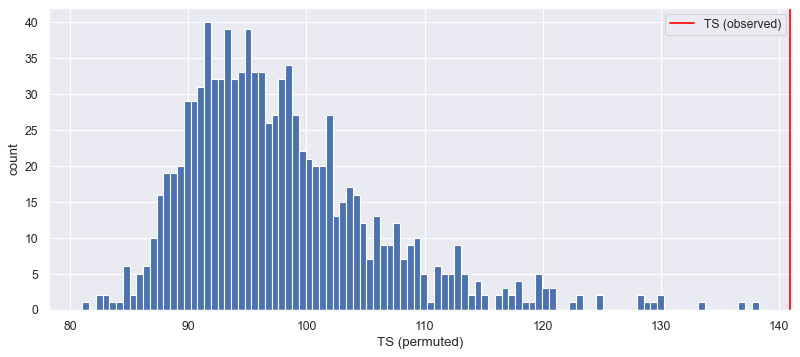

In [57]:
plt.hist(tsp_1, bins=100)
plt.axvline(tso_1, color='red', label= 'TS (observed)')
plt.xlabel('TS (permuted)')
plt.ylabel('count')
plt.legend()
plt.savefig('plots/hist_q1_1.pdf')
plt.show()

In [35]:
d = pd.read_csv('data_1389741.txt', sep=' ')
y = np.squeeze(d[['CRP']].values)
X = d.drop(['CRP'], axis=1).values
X1 = np.squeeze(np.take(X, np.where(clusters_linear == 0), axis=1), axis=1)
X2 = np.squeeze(np.take(X, np.where(clusters_linear == 1), axis=1), axis=1)
print(X1.shape)
print(X2.shape)

(335, 916)
(335, 584)


In [36]:
tso_2, tsp_2 , actual_pval2 = Bootstrap_Fisher(B=1000, X_matrix=X2, y_arr=y)
actual_pval2

0.001998001998001998

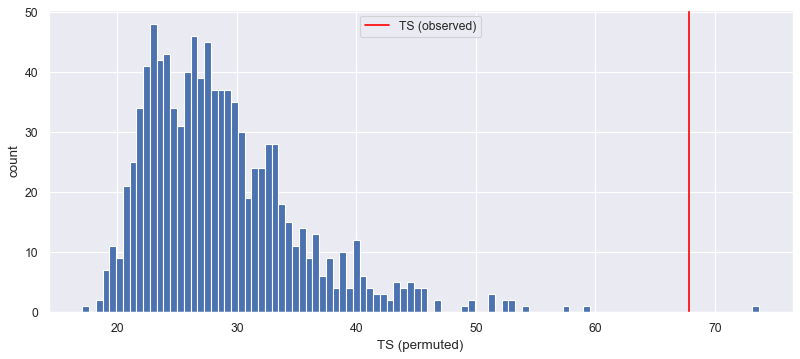

In [58]:
plt.hist(tsp_2, bins=100)
plt.axvline(tso_2, color='red', label= 'TS (observed)')
plt.xlabel('TS (permuted)')
plt.ylabel('count')
plt.legend()
plt.savefig('plots/hist_q1_2.pdf')
plt.show()